In [55]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload  # Python 3.4+

from sklearn import metrics
import seaborn as sns
sns.set()

from pandas import concat, Series


from sklearn.calibration import CalibratedClassifierCV

from IPython.display import clear_output, display

In [56]:
train_df = pd.read_csv('train_for_2012.csv')
train_df.shape

(837913, 44)

In [57]:
test_df = pd.read_csv('test_for_2012.csv')
test_df.shape

(185639, 44)

In [58]:
# df['is_first_occurrence'] = (df['id'] != df['id'].shift()).astype(int)

In [59]:
# modeling_df = df[df['is_first_occurrence']==1].copy()
# print(modeling_df.shape)
# len(modeling_df)/len(df)

In [60]:
train_df['stmt_date'] = pd.to_datetime(train_df['stmt_date'])
train_df['def_date'] = pd.to_datetime(train_df['def_date'], format="%d/%m/%Y")
train_df.sort_values('stmt_date', inplace=True)

In [61]:
### we'll try dropping NA's for now
train_df.sort_values('stmt_date', inplace=True)

In [62]:
test_df['stmt_date'] = pd.to_datetime(test_df['stmt_date'])
test_df['def_date'] = pd.to_datetime(test_df['def_date'], format="%d/%m/%Y")
test_df.sort_values('stmt_date', inplace=True)

## Get preprocessing data ready

In [63]:
from preproc_functions import pre_process

In [64]:
with open('custom_bins.pkl', 'rb') as file:
    custom_bins = pickle.load(file)

In [65]:
preproc_params = {
    'quantile_bins' : {},
    'quantile_values' : {},
    'category_pd': {}
}

In [66]:
train_data_proc , preproc_params = pre_process(train_df, 
                                               custom_bins=custom_bins, 
                                               preproc_params = preproc_params,  
                                               quantiles = 50, 
                                               days_until_statement = 150)

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile
Custom bins for roe_quantile
calc growth features
Custom bins for net_income_growth_quantile


/Users/juanroalvarado/miniconda3/envs/horserace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/juanroalvarado/miniconda3/envs/horserace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


In [67]:
test_data_proc , preproc_params = pre_process(test_df, 
                                             historical_df=train_data_proc, 
                                             new=False, 
                                             preproc_params = preproc_params,  
                                             quantiles = 50, 
                                             days_until_statement = 150)

asst_tot_quantile
financial_leverage_quantile
profitability_ratio_quantile
roe_quantile
quick_ratio_v2_quantile
cash_assets_ratio_quantile
dscr_quantile
using training pds for ateco_sector
using training pds for sector_group
using training pds for regional_code
cfo_quantile
using training pds for legal_struct
calc growth features
net_income_growth_quantile
sales_growth_quantile


In [68]:
len(test_data_proc)==len(test_df)

True

In [69]:
test_data_proc.columns#.tail(10)

Index(['Unnamed: 0', 'id', 'stmt_date', 'HQ_city', 'legal_struct',
       'ateco_sector', 'def_date', 'fs_year', 'asst_intang_fixed',
       'asst_tang_fixed', 'asst_fixed_fin', 'asst_current', 'AR',
       'cash_and_equiv', 'asst_tot', 'eqty_tot', 'eqty_corp_family_tot',
       'liab_lt', 'liab_lt_emp', 'debt_bank_st', 'debt_bank_lt', 'debt_fin_st',
       'debt_fin_lt', 'AP_st', 'AP_lt', 'debt_st', 'debt_lt', 'rev_operating',
       'COGS', 'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations',
       'default', 'asst_tot_quantile', 'asst_tot_quantile_values', 'liab_tot',
       'financial_leverage', 'financial_leverage_quantile',
       'financial_leverage_quantile_values', 'profitability_ratio',
       'profitability_ratio_quantile', 'profitability_ratio_quantile_values',
       'roe_quantile', 'roe_quantile_values', 'net_income',

## Train algorithm

In [70]:
### features for first firm
first_features = [
    # 'asst_tot_quantile_values', ####
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    # 'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    # 'sales_growth_quantile_values',
    # 'cash_assets_ratio_quantile_values', ####
    'dscr_quantile_values',
    'roe_quantile_values',
    'cfo_quantile_values',
    # 'ebitda',
    # 'ateco_sector_pd',
    # 'sector_group_pd', ####
    # 'legal_struct_pd',
    'regional_code_pd' ####
]


In [71]:
### features for recurring firms
rec_features = [
    # 'asst_tot_quantile_values', ###
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    'sales_growth_quantile_values',
    # 'cash_assets_ratio_quantile_values',###
    'dscr_quantile_values',
    'roe_quantile_values',
    'cfo_quantile_values',
    # 'ebitda', ###
    # 'ateco_sector_pd',###
    # 'sector_group_pd',###
    # 'legal_struct_pd',###
    'regional_code_pd'

]

In [72]:
rec_features

['financial_leverage_quantile_values',
 'profitability_ratio_quantile_values',
 'net_income_growth_quantile_values',
 'quick_ratio_v2_quantile_values',
 'sales_growth_quantile_values',
 'dscr_quantile_values',
 'roe_quantile_values',
 'cfo_quantile_values',
 'regional_code_pd']

In [73]:
train_data_proc[rec_features].isna().sum()

financial_leverage_quantile_values     0
profitability_ratio_quantile_values    0
net_income_growth_quantile_values      0
quick_ratio_v2_quantile_values         0
sales_growth_quantile_values           0
dscr_quantile_values                   0
roe_quantile_values                    0
cfo_quantile_values                    0
regional_code_pd                       0
dtype: int64

In [74]:
### features for recurring firms
corr_features = [
    'asst_tot_quantile_values', ###
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',###
    'dscr_quantile_values',
    'roe_quantile_values',
    'cfo_quantile_values',
    # 'ebitda', ###
    'ateco_sector_pd',###
    'sector_group_pd',###
    'legal_struct_pd',###
    'regional_code_pd'

]

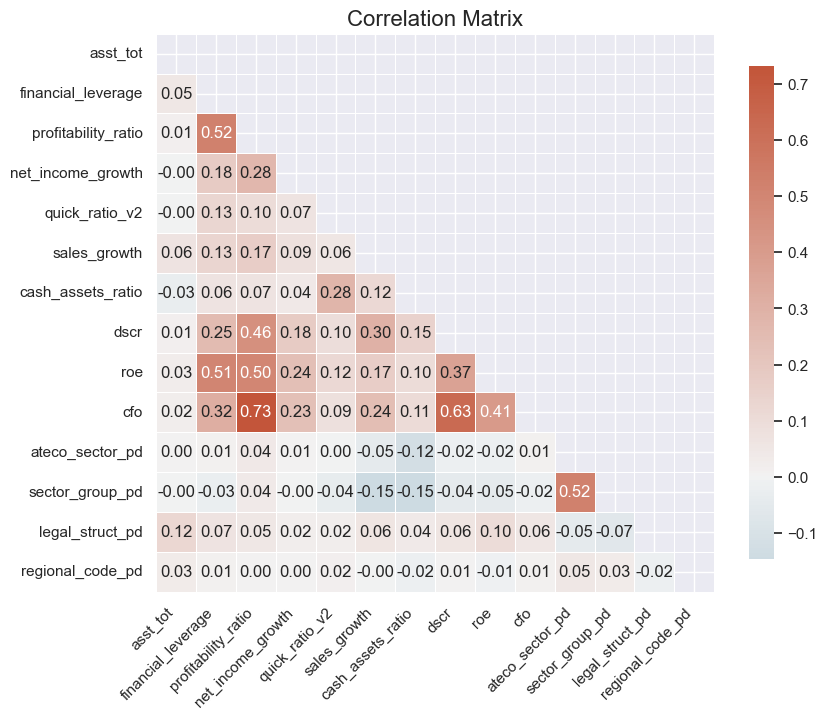

In [75]:
# Compute the correlation matrix
corr = train_data_proc[train_data_proc['is_first_occurrence']==0][corr_features].corr()

# Set up the matplotlib figure
plt.figure(figsize=(9, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)

# Create the heatmap with annotations
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},mask=matrix)

# Set title and display the plot
plt.title("Correlation Matrix", fontsize=16)
ticks = [i.split('_quantile_values')[0] for i in corr.index]
ax.set_xticklabels(ticks, rotation=45, ha='right')
ax.set_yticklabels(ticks, rotation=0, va='center')

# plt.xticks(rotation0)
plt.savefig('cott_matrix.png')
plt.show()


In [78]:
 from statsmodels.stats.outliers_influence import variance_inflation_factor

In [79]:

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_data_proc[corr_features].columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_data_proc[train_data_proc['is_first_occurrence']==0][corr_features].values, i)
                          for i in range(len(train_data_proc[train_data_proc['is_first_occurrence']==0][corr_features].columns))]

In [80]:
vif_data.sort_values('VIF', ascending=False)

,feature,VIF
0,asst_tot_quantile_values,51.264274
11,sector_group_pd,37.024108
13,regional_code_pd,28.824160
12,legal_struct_pd,24.109641
6,cash_assets_ratio_quantile_values,17.463733
10,ateco_sector_pd,12.731101
4,quick_ratio_v2_quantile_values,7.719634
9,cfo_quantile_values,4.208119
5,sales_growth_quantile_values,3.937369
2,profitability_ratio_quantile_values,3.512573


In [81]:

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_data_proc[rec_features].columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_data_proc[train_data_proc['is_first_occurrence']==0][rec_features].values, i)
                          for i in range(len(train_data_proc[train_data_proc['is_first_occurrence']==0][rec_features].columns))]

In [82]:
vif_data.sort_values('VIF', ascending=False)

,feature,VIF
8,regional_code_pd,7.909020
3,quick_ratio_v2_quantile_values,6.381658
7,cfo_quantile_values,4.197874
4,sales_growth_quantile_values,3.711281
1,profitability_ratio_quantile_values,3.473996
5,dscr_quantile_values,3.142687
2,net_income_growth_quantile_values,2.374810
6,roe_quantile_values,2.256744
0,financial_leverage_quantile_values,1.976428


In [83]:

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_data_proc[first_features].columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_data_proc[train_data_proc['is_first_occurrence']==1][first_features].values, i)
                          for i in range(len(train_data_proc[train_data_proc['is_first_occurrence']==1][first_features].columns))]

print(vif_data)

                               feature       VIF
0   financial_leverage_quantile_values  2.016479
1  profitability_ratio_quantile_values  3.182143
2       quick_ratio_v2_quantile_values  6.697786
3                 dscr_quantile_values  2.754737
4                  roe_quantile_values  2.011212
5                  cfo_quantile_values  3.926684
6                     regional_code_pd  6.837453


In [84]:
from xgboost import XGBClassifier
from pandas import concat

In [85]:
class SplitModel():
    def __init__(self, params, first_features, rec_features):
        self.first_features = first_features
        self.rec_features = rec_features

        self.params = params
    
    def train(self, data):
        
        rec_data = data[data['is_first_occurrence']==0]
        first_data = data[data['is_first_occurrence']==1]
        

        self.rec_model = XGBClassifier(**self.params)
        self.first_model = XGBClassifier(**self.params)
        
        self.first_fitted_model = self.first_model.fit(X=first_data[self.first_features], 
                   y=first_data['default'])
        self.rec_fitted_model = self.rec_model.fit(X=rec_data[self.rec_features], 
                   y=rec_data['default'])
        
        print("models fitted")

    def predict(self, data):
        data['prediction_index'] = range(0, len(data))
        rec_data = data[data['is_first_occurrence']==0]
        first_data = data[data['is_first_occurrence']==1]
        print('rec data length',len(rec_data))
        print('first data length',len(first_data))
        
        rec_preds = Series(self.rec_fitted_model.predict_proba(rec_data[self.rec_features])[:,1])
        rec_preds.index = rec_data.prediction_index
        
        first_preds = Series(self.first_fitted_model.predict_proba(first_data[self.first_features])[:,1])
        first_preds.index = first_data.prediction_index

        predictions = concat([rec_preds,first_preds]).reindex(data.prediction_index)
        
        return predictions

    # def summary(self):
    #     print('~~~~~ First Time First Model ~~~~~~')
    #     print(self.first_fitted_model.summary())
    #     print(self.first_fitted_model.get_margeff().summary())
    #     print('\n')
    #     print('~~~~~ Recurring First Model ~~~~~~')
    #     print(self.rec_fitted_model.summary())
    #     print(self.rec_fitted_model.get_margeff().summary())
    #     print('\n')

In [86]:
params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "eta": 0.1,
            "max_depth": 4,
            "min_child_weight": 1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "gamma": 0,
            "alpha": 0.1,
            "lambda": .1,
            "n_estimators":250
         }

model = SplitModel(params = params, 
                   first_features=first_features, 
                   rec_features=rec_features)

In [87]:
model.train(train_data_proc)

models fitted


### Model results

In [88]:
# model.summary()

In [89]:
# train_data_proc.to_csv('train_processed_data_for_2012.csv')
# test_data_proc.to_csv('test_processed_data_for_2012.csv')

## Training metrics

In [90]:
train_preds = model.predict(train_data_proc)

rec data length 612920
first data length 224993


In [91]:
train_results = train_data_proc[['default']].copy()
train_results['predictions'] = train_preds.values

In [92]:
0.8608287802408301

0.8608287802408301

ROC AUC 0.8608287802408301


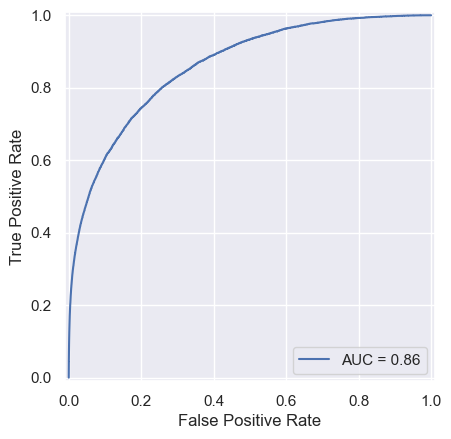

In [93]:
fpr, tpr, thresholds = metrics.roc_curve(train_results['default'], train_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

# hyperparam tuning

In [94]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import roc_auc_score, make_scorer

In [95]:
# param_dist = {
#     'max_depth': [3, 5, 7, 9],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [50, 100, 200, 300],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.5, 1],
#     'reg_alpha': [0, 0.1, 1, 10],
#     'reg_lambda': [1, 5, 10, 20]
# }
# # param_dist = {
# #         'subsample': 0.6,
# #      'reg_lambda': 10,
# #      'reg_alpha': 10,
# #      'n_estimators': 200,
# #      'min_child_weight': 5,
# #      'max_depth': 9,
# #      'learning_rate': 0.05,
# #      'gamma': 0.1,
# #      'colsample_bytree': 1.0}

# # Create the scorer
# scorer = make_scorer(roc_auc_score, needs_proba=True)

In [96]:
# rec_data_opt = train_data_proc[train_data_proc['is_first_occurrence']==0]

In [97]:
# model = XGBClassifier(n_estimators=100)

In [98]:
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=10,  # Number of parameter settings to sample
#     scoring=scorer,
#     cv=3,  # 3-fold cross-validation
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

In [99]:
# random_search.fit(rec_data_opt[rec_features], rec_data_opt['default'])

In [100]:
# results_df = pd.DataFrame(random_search.cv_results_)

# # Sort by the best score in descending order
# sorted_results = results_df.sort_values(by="mean_test_score", ascending=False)

# # Display the top 5 parameter combinations
# print("Top 3 Parameter Combinations:")
# print(sorted_results[['mean_test_score', 'params']].head())

In [101]:
# random_search.best_params_

## Process test data

In [102]:
test_predictions = model.predict(test_data_proc)

rec data length 172921
first data length 12718


In [103]:
test_results = test_data_proc[['default']].copy()
test_results['predictions'] = test_predictions.values

In [104]:
0.8657406548925941

0.8657406548925941

ROC AUC 0.8657406548925941


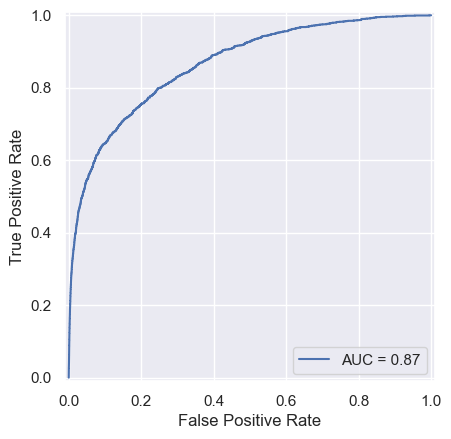

In [105]:
fpr, tpr, thresholds = metrics.roc_curve(test_results['default'], test_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [106]:
# train_data_proc.to_csv('train_processed_data_for_2012.csv', index=False)
# test_data_proc.to_csv('test_processed_data_for_2012.csv', index=False)

## Complete data training and saving components for harness

In [107]:
train = pd.read_csv('../data/train.csv')

In [108]:
train['stmt_date'] = pd.to_datetime(train['stmt_date'])
train['def_date'] = pd.to_datetime(train['def_date'], format="%d/%m/%Y")
train.sort_values('stmt_date', inplace=True)

In [109]:
preproc_params = {
    'quantile_bins' : {},
    'quantile_values' : {},
    'category_pd': {}
}

In [110]:
complete_data , preproc_params = pre_process(train, 
                                           custom_bins=custom_bins, 
                                           preproc_params = preproc_params,  
                                           quantiles = 50, 
                                           days_until_statement = 150)

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile
Custom bins for roe_quantile
calc growth features
Custom bins for net_income_growth_quantile


/Users/juanroalvarado/miniconda3/envs/horserace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/juanroalvarado/miniconda3/envs/horserace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


In [111]:
complete_data.shape, len(train_df)+len(test_df)

((1023552, 84), 1023552)

In [112]:
round(complete_data[complete_data['is_first_occurrence']==1]['default'].value_counts()/ len(complete_data[complete_data['is_first_occurrence']==1]), 3)

default
0    0.99
1    0.01
Name: count, dtype: float64

In [113]:
round(complete_data[complete_data['is_first_occurrence']==0]['default'].value_counts() / len(complete_data[complete_data['is_first_occurrence']==0]), 3)

default
0    0.987
1    0.013
Name: count, dtype: float64

In [114]:
model.train(complete_data)

models fitted


In [115]:
comp_predictions = model.predict(complete_data)

rec data length 785841
first data length 237711


In [116]:
comp_results = complete_data[['default']].copy()
comp_results['predictions'] = comp_predictions.values

In [117]:
comp_results.shape

(1023552, 2)

ROC AUC 0.8598165189610233


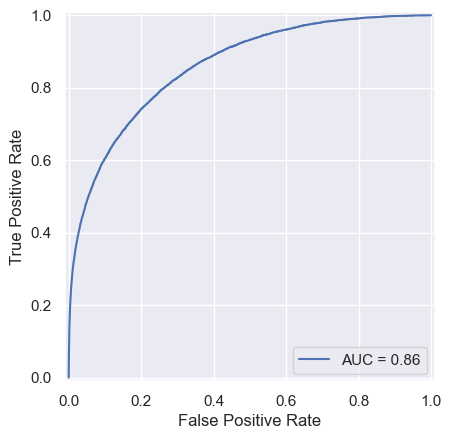

In [141]:
fpr, tpr, thresholds = metrics.roc_curve(comp_results['default'], comp_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [126]:
import calibrator

In [125]:
from importlib import reload

In [134]:
reload(calibrator)

<module 'calibrator' from '/Users/juanroalvarado/nyu/finance/ml-finance-credit-default/final_harness/calibrator.py'>

In [136]:
calibrated_preds = calibrator.calibrator(comp_results['predictions'])

In [144]:
comp_results['predictions'].mean()

np.float32(0.012657084)

In [145]:
comp_results['default'].mean()

np.float64(0.012640295754392546)

In [142]:
calibrated_preds.head()

4    0.016934
1    0.144114
2    0.078240
5    0.040764
0    0.041071
Name: predictions, dtype: float32

In [143]:
calibrated_preds.mean()

np.float32(0.024982385)

In [138]:
calibrated_preds.isna().sum()

np.int64(0)

ROC AUC 0.8598165190375033


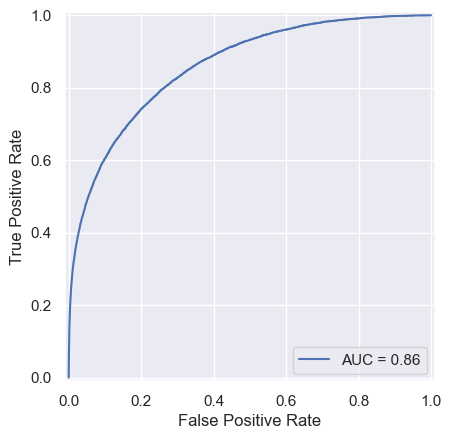

In [139]:
fpr, tpr, thresholds = metrics.roc_curve(comp_results['default'], calibrated_preds)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [200]:
growth_features = [
    'id',
    'stmt_date',
    'net_income',
    'sales'
]

In [201]:
historical_growth = complete_data[growth_features]#.to_csv('historical_features.csv')
historical_growth.head()

,id,stmt_date,net_income,sales
4,520288,2007-12-31,36733.0,2041155.0
1,520288,2008-12-31,-107382.0,967389.0
2,520288,2009-12-31,-77819.0,638687.0
5,520288,2010-12-31,-83593.0,564622.0
0,520288,2011-12-31,-81288.0,538081.0


In [202]:
historical_growth.shape

(1023552, 4)

In [203]:
custom_bins.keys()

dict_keys(['financial_leverage_quantile', 'profitability_ratio_quantile', 'net_income_growth_quantile', 'roe_quantile'])

In [204]:
for k in preproc_params.keys():
    print(k, preproc_params[k].keys())

quantile_bins dict_keys(['asst_tot_quantile', 'financial_leverage_quantile', 'profitability_ratio_quantile', 'roe_quantile', 'quick_ratio_v2_quantile', 'cash_assets_ratio_quantile', 'dscr_quantile', 'cfo_quantile', 'net_income_growth_quantile', 'sales_growth_quantile'])
quantile_values dict_keys(['asst_tot_quantile', 'financial_leverage_quantile', 'profitability_ratio_quantile', 'roe_quantile', 'quick_ratio_v2_quantile', 'cash_assets_ratio_quantile', 'dscr_quantile', 'cfo_quantile', 'net_income_growth_quantile', 'sales_growth_quantile'])
category_pd dict_keys(['ateco_sector_pd_values', 'sector_group_pd_values', 'regional_code_pd_values'])


In [205]:
historical_growth.to_csv('historical_features.csv')

In [206]:
with open('custom_bins.pkl', 'wb') as output:
    pickle.dump(custom_bins, output)

In [207]:
with open('preproc_params.pkl', 'wb') as output:
    pickle.dump(preproc_params, output)

In [208]:
with open('trained_model.pkl', 'wb') as output:
    pickle.dump(model, output)

In [209]:

# train = pd.read_csv('../data/train.csv')
# train.sample(10000).to_csv('harness_test.csv',index=False)